
# Pairwise differences in 100kb windows between male X chromosomes

This notebook compiles data sets with pairwise distances for all male haplotypes. The distances between each pair of individuals are computed using the GWF workflow. 


The data set consists of male X chromosomes from the Simons Genome Diversity project. We exclude males with missing data (as in Mallick et al.) and males not showing the XY karyotype (Lucotte et al. 2018). We further removed African males with evidence of recent European admixture. These are the `exlcuded_populations` in `analysis_globals.py`.

There are two sets of window stats: one set including all data and another set where called archaic segmnets are ignored when computing distances. The columns names for the latter set of statistics have a `_af` suffix (for admixture filtered).

In [2]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

numpy.random.seed(7)

Import variables global to the entire analysis:

In [3]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [4]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Convenience functions:

In [5]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

Plotting setup:

In [6]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

Ignore warnings:

In [7]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

## Load meta data

Easy loading of meta data in a consistent manner across code

In [8]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

Write a file with the analyzed individuals form import into manuscript:

In [9]:
records = list()
for indiv, d in individuals.items():
    if d['Genetic sex assignment'] == 'XY':
        records.append((indiv, d['Population ID'], d['Region']))
analyzed_individuals = (DataFrame.from_records(records, 
                                              columns=['Sample ID', 'Population', 'Region'])
                        .sort_values(by=['Region', 'Population'])
                       )
analyzed_individuals.to_csv(ag.results_dir / 'analyzed_individuals.csv', index=False)

## Load pairwise distances

Read in HDF store made in the GWF workflow:

In [ ]:
male_dist_data_chrX = pandas.read_hdf(ag.steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb.store')

Include only the individuals we decided to include in the analysis:

In [ ]:
indiv_mask = numpy.bitwise_and(male_dist_data_chrX.indiv_1.isin(individuals),
                               male_dist_data_chrX.indiv_2.isin(individuals))

male_dist_data_chrX = male_dist_data_chrX.loc[indiv_mask]


# pairwise distances with ampliconic regions masked out
#male_dist_data_chrX = pandas.read_hdf(steps_dir / 'male_dist_ampl_and_admix_masked_stores/male_dist_data_chrX_100kb.store')

In [ ]:
male_dist_data_chrX.head()

Distribution of number of possitions in each window where at least one or both sequences in a pair has an uncalled base:

In [ ]:
g = sns.distplot(male_dist_data_chrX.uncalled)

In [ ]:
print("Cutoff for number of uncalled bases is", ag.max_uncalled_bases)

## All pairwise distances

The data frame `male_dist_data_chrX` only has each pair represented once. To have all individuals represeted as both `indiv_1` and `indiv_2`, we make the data frame below that holds distances for all individuals to all other individuals.

First we drop the `pop_label` columns and add `pop_1` and `pop_2` columns:

In [ ]:
male_dist_data_chrX.drop('pop_label', axis=1, inplace=True)

male_dist_data_chrX['pop_1'] = [individuals[x]['Population ID'] for x in male_dist_data_chrX.indiv_1]
male_dist_data_chrX['pop_2'] = [individuals[x]['Population ID'] for x in male_dist_data_chrX.indiv_2]

Then we make a data set with one row for each male individual for each window:

In [ ]:
# dict for swapping columns
swap_dict = dict()
for colname in male_dist_data_chrX.columns.values:
    if colname.endswith('_1'):
        swap_dict[colname] = colname[:-2] + '_2'
    if colname.endswith('_2'):
        swap_dict[colname] = colname[:-2] + '_1'
        
# pop_mask = ~numpy.bitwise_or(male_dist_data_chrX.pop_1.isin(ag.excluded_pops),
#                              male_dist_data_chrX.pop_2.isin(ag.excluded_pops))

# print(len(pop_mask))
# print(sum(pop_mask))


cols = ['start', 'end', 'indiv_1', 'indiv_2', 
        'dist', 'mismatch', 'match', 
        'dist_af', 'mismatch_af', 'match_af',
        'uncalled', 'pop_1', 'pop_2',
        'region_label_1', 'region_label_2', 
        'region_id_1', 'region_id_2', 'region_1', 'region_2']

# all_male_dist_twice = (pandas.concat([male_dist_data_chrX[cols].loc[pop_mask],
#                                       male_dist_data_chrX[cols].loc[pop_mask].rename(columns=swap_dict)])
all_male_dist_twice = (pandas.concat([male_dist_data_chrX[cols],
                                      male_dist_data_chrX[cols].rename(columns=swap_dict)])
      .sort_values(['indiv_1', 'start'])
      .reset_index(drop=True)
      )
# sanity checks
print(len(all_male_dist_twice.indiv_1.unique()))
print(len(all_male_dist_twice.indiv_2.unique()))
s1 = set(all_male_dist_twice.indiv_1.unique())
s2 = set(all_male_dist_twice.indiv_2.unique())
print(len(s1.union(s2)))
print(2 * 173*172/2)
print(len(all_male_dist_twice[['indiv_1', 'indiv_2']].drop_duplicates()))

In [ ]:
all_male_dist_twice.columns

We also make a 1Mb version just in case:

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore all-nan warnings

    all_male_dist_twice_1Mb = (all_male_dist_twice
                               .assign(binlab = lambda df: [x // 1000000 for x in df.start])
                               .groupby(['indiv_1', 'indiv_2', 'binlab'])
                               .aggregate({'start': min,
                                           'end': max,
                                           'dist': numpy.nanmean,
                                           'match': numpy.nanmean,
                                           'mismatch': numpy.nanmean,
                                           'dist_af': numpy.nanmean,
                                           'match_af': numpy.nanmean,
                                           'mismatch_af': numpy.nanmean,
                                           'uncalled': numpy.nanmean,
                                           'pop_1': ident_scalar,
                                           'region_1': ident_scalar,
                                           'region_id_1': ident_scalar,
                                           'region_label_1': ident_scalar,
                                           'pop_2': ident_scalar,
                                           'region_2': ident_scalar,
                                           'region_id_2': ident_scalar,
                                           'region_label_2': ident_scalar})
                               .reset_index(level=['indiv_1', 'indiv_2', 'binlab'])
                               .assign(start = lambda df: df.binlab * 1000000,
                                       end = lambda df: df.binlab * 1000000 + 1000000)
                           )

We replace distances with NaN where the number of comparable called bases in each window is not high enough. So when `dist` is `nan` the observation is missing.

In [ ]:
all_male_dist_twice.dist.where(all_male_dist_twice.uncalled <= ag.max_uncalled_bases, 
                               inplace=True)

We apply *same* mask to `dist_af`. I.e. we do not count masked admixture segments as uncalled. This is to retain the same power for calling sweeps with admxiture removed.

In [ ]:
all_male_dist_twice.dist_af.where(all_male_dist_twice.uncalled <= ag.max_uncalled_bases, 
                               inplace=True)

Write the big table to HDF:

In [ ]:
all_male_dist_twice.to_hdf(ag.results_dir / 'all_male_dist_twice.hdf', 'df', 
                           data_columns=['start', 'end', 
                                         'indiv_1', 'indiv_2', 
                                         'pop_1', 'pop_2', 
                                         'region_label_1', 'region_label_2'],
                           format="table", mode='w')

Apply mask to 1Mb data set and write to HDF:

In [ ]:
# mask
all_male_dist_twice_1Mb.dist.where(all_male_dist_twice_1Mb.uncalled <= ag.max_uncalled_bases, 
                                   inplace=True)

In [ ]:
all_male_dist_twice_1Mb.to_hdf(ag.results_dir / 'all_male_dist_twice_1Mb.hdf', 'df',
                               data_columns=['start', 'end', 
                                             'indiv_1', 'indiv_2', 
                                             'pop_1', 'pop_2', 
                                             'region_label_1', 'region_label_2'],
                               format="table", mode='w')

## Distribution of distances Africa and non-Africa

Here we compare the distributions of pairwise distances for Africans and non-Africans. We make a column `is_oaa` to label group non-African individuals:

In [ ]:
#all_male_dist_twice = pandas.read_hdf(ag.results_dir / 'all_male_dist_twice.hdf')

In [10]:
# plot_df = all_male_dist_twice.assign(is_ooa=lambda df: df.region_1 != 'Africa')

plot_df = (all_male_dist_twice
           .assign(afr_pair=(all_male_dist_twice.region_1 == 'Africa') & (all_male_dist_twice.region_2 == 'Africa'),
                   nonafr_pair=(all_male_dist_twice.region_1 != 'Africa') & (all_male_dist_twice.region_2 != 'Africa'))
           .loc[lambda df: df.afr_pair | df.nonafr_pair]
           .assign(is_ooa=lambda df: df.region_1 != 'Africa')
          )
len(plot_df), plot_df.is_ooa.sum()

(30918944, 30201920)

Get the number of pairwise differences that are above and below our cutoff for pairwise distance:

In [11]:
(plot_df
 .assign(below_cut=lambda df: df['dist'] <= ag.pwdist_cutoff)
 .groupby(['below_cut', 'is_ooa'])
 .size()
)

below_cut  is_ooa
False      False       704788
           True      25843316
True       False        12236
           True       4358604
dtype: int64

Do the same for the admixture filtered distances:

In [12]:
(plot_df
 .assign(below_cut=lambda df: df['dist_af'] <= ag.pwdist_cutoff)
 .groupby(['below_cut', 'is_ooa'])
 .size()
)

below_cut  is_ooa
False      False       704730
           True      25797320
True       False        12294
           True       4404600
dtype: int64

Plot the distribution of distances:

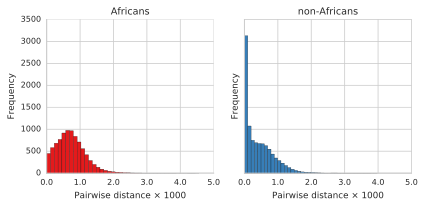

In [13]:
with sns.plotting_context('paper'):
    with sns.axes_style('whitegrid'):
        g = sns.FacetGrid(plot_df, 
                          col="is_ooa",  hue="is_ooa",
                          palette='Set1')
        g = g.map(plt.hist, "dist", normed=True, bins=40)
                        
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
            
        for ax in g.axes.flat:
            ax.set_xlabel('Pairwise distance × 1000')
            ax.set_ylabel('Frequency')

            titles = {'True': 'non-Africans', 'False': 'Africans'}
            ax.set_title(titles[ax.get_title()])
            
            def format_func(value, tick_number):
                return str(value*1000)

            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

        plt.tight_layout()

In [14]:
#len(plot_df.loc[(plot_df.dist >= 0.002) & (plot_df.region_1 == 'Africa')])
len(plot_df.loc[(plot_df.dist >= 0.002)])

111232

In [15]:
hist_cut = 0.002

#plot_df['trunc_dist'] = plot_df.dist.where(plot_df.dist <= hist_cut, hist_cut)

plot_df['trunc_dist'] = plot_df.dist
plot_df.loc[plot_df.dist > hist_cut, 'trunc_dist'] = hist_cut


In [16]:
#plt.hist(plot_df.dist)

In [17]:
#len(plot_df.loc[(plot_df.trunc_dist == 0.002) & (plot_df.region_1 == 'Africa')])
len(plot_df.loc[(plot_df.trunc_dist >= 0.002)])

111232

In [18]:
len(plot_df)

30918944

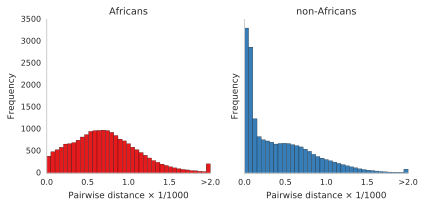

In [49]:
with sns.plotting_context('paper'):
    with sns.axes_style('whitegrid', {'axes.grid' : False}):
        g = sns.FacetGrid(plot_df, 
                          col="is_ooa",  hue="is_ooa",
                          palette='Set1')
        g = g.map(plt.hist, "trunc_dist", normed=True, bins=numpy.linspace(0, 2e-3, num= 2e-3 / 5e-5))
                        
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
            
        for ax in g.axes.flat:
            ax.set_xlabel('Pairwise distance × 1/1000')
            ax.set_ylabel('Frequency')

            titles = {'True': 'non-Africans', 'False': 'Africans'}
            ax.set_title(titles[ax.get_title()])
            
            def format_func(value, tick_number):
                lab = str(value*1000)
                if value == hist_cut:
                    return '>{}'.format(lab)
                return lab

            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

        plt.tight_layout()
        
        plt.savefig(str(ag.figures_dir / 'distr_dist_afr_nonafr_no_dashed.pdf'))

and a version with a dashed line for the cutoff:

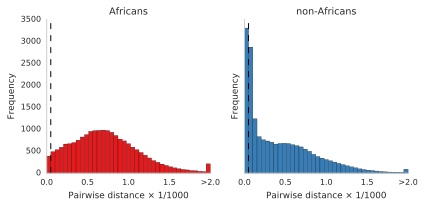

In [44]:
with sns.plotting_context('paper'):
    with sns.axes_style('whitegrid', {'axes.grid' : False}):
        g = sns.FacetGrid(plot_df, 
                          col="is_ooa",  hue="is_ooa",
                          palette='Set1')
        g = g.map(plt.hist, "trunc_dist", normed=True, bins=numpy.linspace(0, 2e-3, num= 2e-3 / 5e-5))

        for ax in g.axes.flat:
            ax.axvline(ag.pwdist_cutoff, color='black', linestyle='dashed', linewidth=1)
                        
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
            
        for ax in g.axes.flat:
            ax.set_xlabel('Pairwise distance × 1/1000')
            ax.set_ylabel('Frequency')
            
            titles = {'True': 'non-Africans', 'False': 'Africans'}
            ax.set_title(titles[ax.get_title()])
            
            def format_func(value, tick_number):
                lab = str(value*1000)
                if value == hist_cut:
                    return '>{}'.format(lab)
                return lab

            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

        plt.tight_layout()            
            
        plt.savefig(str(ag.figures_dir / 'distr_dist_afr_nonafr.pdf'))
        plt.savefig(str(ag.figures_dir / 'distr_dist_afr_nonafr.png'))

The same plot stratified by region label of indiv_1:

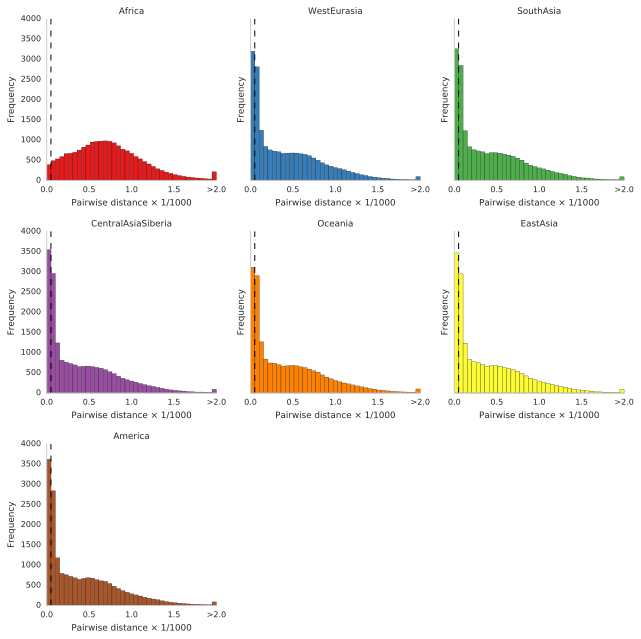

In [45]:
with sns.plotting_context('paper'):
    with sns.axes_style('whitegrid', {'axes.grid' : False}):
        g = sns.FacetGrid(plot_df, 
                          col="region_1",  hue="region_1",
                          sharex=False, # to put tics on all x-axes
                          palette='Set1', 
                          col_wrap=3)

        g = g.map(plt.hist, "trunc_dist", normed=True, bins=numpy.linspace(0, 2e-3, num= 2e-3 / 5e-5))
        
        for ax in g.axes.flat:
            ax.axvline(ag.pwdist_cutoff, color='black', linestyle='dashed', linewidth=1)
            ax.set_ylabel('Frequency')
            ax.set_xlabel('Pairwise distance × 1/1000')
            
            def format_func(value, tick_number):
                lab = str(value*1000)
                if value == hist_cut:
                    return '>{}'.format(lab)
                return lab

            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))


        g.set_titles(row_template="{row_name}", col_template="{col_name}")
        
        plt.tight_layout()
            
        plt.savefig(str(ag.figures_dir / 'distr_dist_by_indiv_region.pdf'))
        plt.savefig(str(ag.figures_dir / 'distr_dist_by_indiv_region.png'))

Same but with a log x-axis:

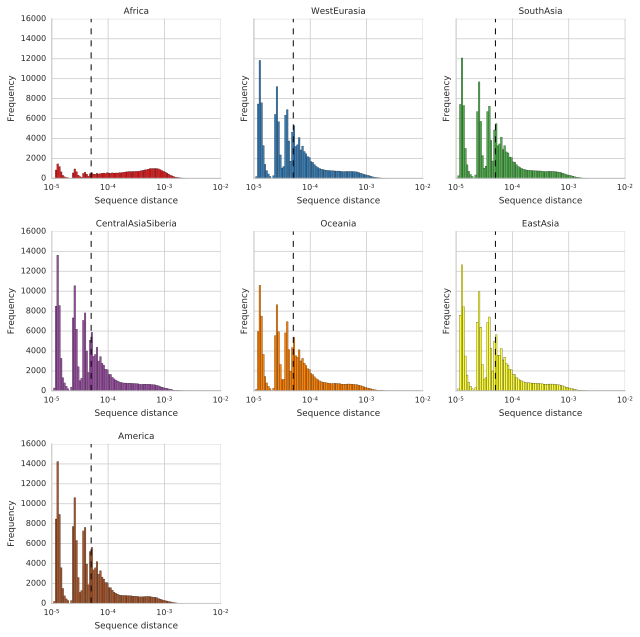

In [39]:
with sns.plotting_context('paper'):
    with sns.axes_style('whitegrid', {'axes.grid' : False}):
        g = sns.FacetGrid(plot_df, # all_male_dist_twice.loc[lambda df: df.dist < 0.001], 
                          col="region_1",  hue="region_1",
                          palette='Set1', 
                          sharex=False, # to put tics on all x-axes
                          col_wrap=3)
            
        g = g.map(plt.hist, "dist", normed=True, 
                  bins=numpy.logspace(numpy.log10(1e-5),numpy.log10(1e-2), 100)
                 )
        for ax in g.axes.flat:
            ax.axvline(ag.pwdist_cutoff, color='black', linestyle='dashed', linewidth=1)
            ax.set_xscale("log", nonposx='clip')

            ax.set_ylabel('Frequency')
            ax.set_xlabel('Sequence distance')
                
        g.set_titles(row_template="{row_name}", col_template="{col_name}")
        
        plt.tight_layout()
        
        plt.savefig(str(ag.figures_dir / 'distr_dist_by_indiv_region_log.pdf'))
        plt.savefig(str(ag.figures_dir / 'distr_dist_by_indiv_region_log.png'))